[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv12 Object Detection on a Custom Dataset

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolov12-object-detection-model.ipynb)
[![arXiv](https://img.shields.io/badge/arXiv-2502.12524-b31b1b.svg)](https://arxiv.org/abs/2502.12524)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov12-model)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/sunsmarterjie/yolov12)

[YOLOv12](https://github.com/sunsmarterjie/yolov12) is a newly proposed attention-centric variant of the YOLO family that focuses on incorporating efficient attention mechanisms into the backbone while preserving real-time performance. Instead of relying heavily on CNN-based architectures like its predecessors, YOLOv12 introduces a simple yet powerful “area attention” module, which strategically partitions the feature map to reduce the quadratic complexity of full self-attention. It also adopts residual efficient layer aggregation networks (R-ELAN) to enhance feature aggregation and training stability, especially for larger models. These innovations, together with refinements such as scaled residual connections and a reduced MLP ratio, enable YOLOv12 to harness the benefits of attention (e.g., better global context modeling) without sacrificing speed.

![yolov12-area-attention](https://media.roboflow.com/notebooks/examples/yolov12-area-attention.png)

Compared to prior YOLO iterations (e.g., YOLOv10, YOLOv11, and YOLOv8), YOLOv12 achieves higher detection accuracy with competitive or faster inference times across all model scales. Its five sizes—N, S, M, L, and X—range from 2.6M to 59.1M parameters, striking a strong accuracy–speed balance. For instance, the smallest YOLOv12-N surpasses other “nano” models by over 1% mAP with latency around 1.6 ms on a T4 GPU, and the largest YOLOv12-X achieves 55.2% mAP, comfortably outscoring comparable real-time detectors such as RT-DETR and YOLOv11-X . By matching or exceeding state-of-the-art accuracy while remaining fast, YOLOv12 represents a notable step forward for attention-based real-time object detection.

![yolov12-metrics](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov12-metrics.png)

## Environment setup

### Configure your API keys

To fine-tune YOLOv12, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [1]:
import os
from google.colab import userdata

os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")

### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [2]:
!nvidia-smi

Fri May 23 04:10:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [4]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 50.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 129.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Download example data

Let's download an image we can use for YOLOv12 inference. Feel free to drag and drop your own images into the Files tab on the left-hand side of Google Colab, then reference their filenames in your code for a custom inference demo.

In [5]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="7rUGB5ubV9BzihCwI5Eb")
project = rf.workspace("firedetection-sserj").project("fire_detection-uhbdr")
version = project.version(8)
dataset = version.download("yolov12")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Fire_Detection-8 in yolov12:: 100%|██████████| 173246/173246 [00:35<00:00, 4879.50it/s]


## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

In [6]:
from tqdm import tqdm
import os
import json
from PIL import Image

# === Cấu hình ===
img_dir = '/content/Fire_Detection-8/valid/images'
label_dir = '/content/Fire_Detection-8/valid/labels'
output_json = '/content/annotations_val.json'
class_names = ['Fire', 'Smoke']

# === Khởi tạo COCO dict ===
coco = {
    "images": [],
    "annotations": [],
    "categories": [{"id": i, "name": name} for i, name in enumerate(class_names)]
}

annotation_id = 0

for i, filename in enumerate(tqdm(os.listdir(img_dir))):
    if not filename.endswith(".jpg") and not filename.endswith(".png"):
        continue
    img_path = os.path.join(img_dir, filename)
    label_path = os.path.join(label_dir, filename.rsplit(".", 1)[0] + ".txt")

    image = Image.open(img_path)
    width, height = image.size

    coco["images"].append({
        "id": i,
        "file_name": filename,
        "width": width,
        "height": height
    })

    if not os.path.exists(label_path):
        continue

    with open(label_path, "r") as f:
        for line in f:
            values = list(map(float, line.strip().split()))
            if len(values) != 5:
                continue  # bỏ qua lỗi format

            cls, x_center, y_center, w, h = values
            x = (x_center - w / 2) * width
            y = (y_center - h / 2) * height
            w *= width
            h *= height

            coco["annotations"].append({
                "id": annotation_id,
                "image_id": i,
                "category_id": int(cls),
                "bbox": [x, y, w, h],
                "area": w * h,
                "iscrowd": 0
            })
            annotation_id += 1

# === Ghi ra file JSON ===
with open(output_json, "w") as f:
    json.dump(coco, f)

print(f"✅ COCO annotation saved to: {output_json}")


100%|██████████| 12468/12468 [00:01<00:00, 7897.39it/s]


✅ COCO annotation saved to: /content/annotations_val.json


## Download dataset from Roboflow Universe

In [7]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import json

# === Load ground truth (COCO-formatted) ===
coco_gt = COCO("/content/annotations_val.json")

# === Load prediction file ===
with open("/content/runs/detect/val/predictions.json", "r") as f:
    coco_pred = json.load(f)

# === Convert predictions to COCO format ===
coco_dt = coco_gt.loadRes(coco_pred)

# === Initialize COCOeval ===
coco_eval = COCOeval(coco_gt, coco_dt, iouType="bbox")

# === Run evaluation ===
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()


loading annotations into memory...
Done (t=0.16s)
creating index...
index created!


FileNotFoundError: [Errno 2] No such file or directory: '/content/runs/detect/val/predictions.json'

In [14]:
!yolo val model=/content/best.pt data=/content/Fire_Detection-8/data.yaml save_json=True


FlashAttention is not available on this device. Using scaled_dot_product_attention instead.
Ultralytics 8.3.63 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12m summary (fused): 402 layers, 19,578,070 parameters, 0 gradients, 59.5 GFLOPs
100% 755k/755k [00:00<00:00, 14.6MB/s]
val: Scanning /content/Fire_Detection-8/valid/labels... 12468 images, 30 backgrounds, 0 corrupt: 100% 12468/12468 [00:05<00:00, 2364.44it/s]
val: WARNING ⚠️ /content/Fire_Detection-8/valid/images/NEWFireVideo10_f25_jpg.rf.1885f5e400ba79fc2aea57a32392bf0a.jpg: 1 duplicate labels removed
val: New cache created: /content/Fire_Detection-8/valid/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 316, len(boxes) = 31507. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R     

**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [31]:
!pip install -q gdown
import gdown

# File ID
file_id = "1gprzH_phkRMy9CqDUeXhtn-uuzPbQ5gR"
# URL dạng direct download
url = f"https://drive.google.com/uc?id={file_id}"

# Tải file về
gdown.download(url, output="best.pt", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1gprzH_phkRMy9CqDUeXhtn-uuzPbQ5gR
From (redirected): https://drive.google.com/uc?id=1gprzH_phkRMy9CqDUeXhtn-uuzPbQ5gR&confirm=t&uuid=d95cf34e-78a9-4c37-acfb-1a73ea3945ba
To: /content/best.pt
100%|██████████| 39.7M/39.7M [00:00<00:00, 54.9MB/s]


'best.pt'

In [35]:
# Giả sử bạn có prediction từ model YOLO
from ultralytics import YOLO
import json
import os
import cv2

model = YOLO("best.pt")
img_dir = "/content/Fire_Detection-8/valid/images"

coco_predictions = []

# Optional: mapping filename to image_id (int) từ annotation
with open("/content/annotations_val.json") as f:
    coco_gt = json.load(f)
image_map = {img["file_name"]: img["id"] for img in coco_gt["images"]}

for fname in os.listdir(img_dir):
    if not fname.endswith(".jpg"):
        continue
    path = os.path.join(img_dir, fname)
    results = model(path)[0]
    for box, cls, score in zip(results.boxes.xywh, results.boxes.cls, results.boxes.conf):
        coco_predictions.append({
            "image_id": image_map.get(fname, -1),
            "category_id": int(cls.item()),
            "bbox": [
                float(box[0] - box[2]/2),
                float(box[1] - box[3]/2),
                float(box[2]),
                float(box[3])
            ],
            "score": float(score.item())
        })

# Remove entries with image_id=-1 (không map được)
coco_predictions = [p for p in coco_predictions if p["image_id"] != -1]

with open("predictions_fixed.json", "w") as f:
    json.dump(coco_predictions, f)


Streaming output truncated to the last 5000 lines.
image 1/1 /content/Fire_Detection-8/valid/images/fire_00787_jpg.rf.07dcbc6c7c0b6e603911747cb0cfdb18.jpg: 640x640 1 Fire, 1 Smoke, 27.2ms
Speed: 2.5ms preprocess, 27.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/Fire_Detection-8/valid/images/middle_-1602-_jpg.rf.f831f2e24196bd3a5fda084eec649cba.jpg: 640x640 2 Fires, 26.7ms
Speed: 2.3ms preprocess, 26.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/Fire_Detection-8/valid/images/09088_jpg.rf.e6e979281016963bf4e49e1b470487cd.jpg: 640x640 (no detections), 26.2ms
Speed: 2.4ms preprocess, 26.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/Fire_Detection-8/valid/images/NEWFireVideo156_f184_jpg.rf.6fb8b9e4a0904c31b56d52fac4f2a4ad.jpg: 640x640 1 Smoke, 26.3ms
Speed: 2.5ms preprocess, 26.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /conten

## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [16]:
# Load ground truth COCO annotations
coco_gt = COCO("/content/annotations_val.json")
img_dict = {img["file_name"]: img["id"] for img in coco_gt.dataset["images"]}

# Load predictions
with open("/content/runs/detect/val3/predictions.json") as f:
    preds = json.load(f)

# Fix predictions
fixed_preds = []
for pred in preds:
    file_name = pred.get("file_name")  # hoặc tùy key bạn dùng
    if file_name and file_name in img_dict:
        pred["image_id"] = img_dict[file_name]
        fixed_preds.append(pred)
    elif "image_id" in pred and isinstance(pred["image_id"], str):
        base = pred["image_id"].split("/")[-1]
        pred["image_id"] = img_dict.get(base, -1)
        if pred["image_id"] != -1:
            fixed_preds.append(pred)

# Lưu lại
with open("/content/predictions_fixed.json", "w") as f:
    json.dump(fixed_preds, f)


loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


## Evaluate fine-tuned YOLOv12 model

In [17]:
coco_dt = coco_gt.loadRes("/content/predictions_fixed.json")
coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()


Loading and preparing results...


IndexError: list index out of range

In [21]:
!yolo val model=/content/best.pt data=/content/Fire_Detection-8/data.yaml save_json=True


FlashAttention is not available on this device. Using scaled_dot_product_attention instead.
Ultralytics 8.3.63 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12m summary (fused): 402 layers, 19,578,070 parameters, 0 gradients, 59.5 GFLOPs
val: Scanning /content/Fire_Detection-8/valid/labels.cache... 12468 images, 30 backgrounds, 0 corrupt: 100% 12468/12468 [00:00<?, ?it/s]
val: WARNING ⚠️ /content/Fire_Detection-8/valid/images/NEWFireVideo10_f25_jpg.rf.1885f5e400ba79fc2aea57a32392bf0a.jpg: 1 duplicate labels removed
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 316, len(boxes) = 31507. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 780/780 [07:36<00:00,  1.71it/s]
                   all      12468      31507      0.666

In [22]:
import json
with open("runs/detect/val4/predictions.json") as f:
    data = json.load(f)

print("Số lượng prediction:", len(data))
if len(data):
    print("Ví dụ:", data[0])


Số lượng prediction: 1682526
Ví dụ: {'image_id': 'youtube-9_jpg.rf.9639e1e9a71eb3e20187728d82ddaaa9', 'category_id': 2, 'bbox': [433.594, 1.671, 203.392, 343.473], 'score': 0.21987}


In [24]:
from pycocotools.coco import COCO
coco_gt = COCO("/content/annotations_val.json")


loading annotations into memory...
Done (t=0.16s)
creating index...
index created!


In [26]:
from pycocotools.coco import COCO
import json

# === Load annotation gốc
coco_gt = COCO("/content/annotations_val.json")

# === Load prediction
with open("/content/runs/detect/val4/predictions.json", "r") as f:
    predictions = json.load(f)

# === Tạo map filename → id từ annotation gốc
img_name_to_id = {img["file_name"].split("/")[-1].replace(".jpg", "").replace(".png", ""): img["id"] for img in coco_gt.dataset["images"]}

# === Convert string image_id → int id
for p in predictions:
    original_id = p["image_id"].split("/")[-1].replace(".jpg", "").replace(".png", "")
    p["image_id"] = img_name_to_id.get(original_id, -1)

# === Lọc prediction hợp lệ
predictions = [p for p in predictions if p["image_id"] != -1]

# ✅ Nếu predictions vẫn rỗng
if not predictions:
    raise ValueError("❌ Không còn prediction nào hợp lệ sau khi chuyển image_id! Hãy kiểm tra lại tên ảnh.")

# === Đánh giá
from pycocotools.cocoeval import COCOeval
coco_dt = coco_gt.loadRes(predictions)
coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()


loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
Loading and preparing results...
DONE (t=4.59s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=24.50s).
Accumulating evaluation results...
DONE (t=8.10s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.007
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.041
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

FlashAttention is not available on this device. Using scaled_dot_product_attention instead.

image 1/1 /content/fire.jpeg: 448x640 1 Fire, 130.6ms
Speed: 3.4ms preprocess, 130.6ms inference, 155.3ms postprocess per image at shape (1, 3, 448, 640)


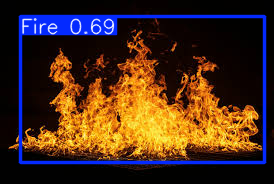

In [32]:
from ultralytics import YOLO
model = YOLO("best.pt")
results = model("fire.jpeg")[0]
results.show()


In [34]:
# Dòng ví dụ
prediction = {
  "image_id": "youtube-9_jpg.rf.9639e1e9a71eb3e20187728d82ddaaa9"
}
# COCO annotation phải có ID trùng hoặc quy đổi chính xác


## Run inference with fine-tuned YOLOv12 model

In [ ]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

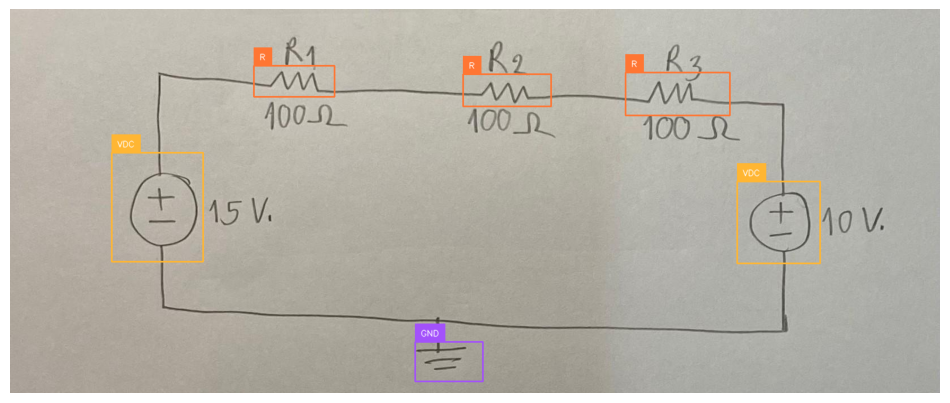

In [ ]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)